In [159]:
%matplotlib inline

In [160]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from condlib import conductance_matrix_CAMREAD
from timeit import default_timer as timer

In [161]:
# Memory array parameters
rL = 12
rHRS = 1e6
n = 16
vRead = [0.5, 1.0, 1.6, 2.0, 2.5, 3.0, 4.0]

np.random.seed(0)
BLpattern_random = np.random.randint(0, 2, n).astype(bool)
BLpattern_random[n - 1] = False           # set last bit to 0
BLpattern_random[0] = False               # set first bit to 0
BLpattern_ones = np.ones(n).astype(bool)
BLpattern_ones[n - 1] = False             # set last bit to 0
BLpattern_ones[0] = False                 # set first bit to 0
BLpattern_zeros = np.zeros(n).astype(bool)

pat_type = 'random'

In [162]:
hubList = []
lsbList = []
WLvoltagesList = []
BLvoltagesList = []
cellVoltagesList = []
mask = np.vstack((np.ones((n-1, n), dtype=bool), np.zeros(n, dtype=bool)))

In [163]:
for v in vRead:
    # Voltages for BLs and WLs (read voltages, unselected WLs V/2, BL are 0 or V)
    vWLsel = v
    vWLnsel = v / 2.0
    vBL0 = 0.0
    vBL1 = v

    if pat_type == 'random':
        jpattern = BLpattern_random
    if pat_type == 'ones':
        jpattern = BLpattern_ones
    if pat_type == 'zeros':
        jpattern = BLpattern_zeros

    start_t = timer()
    # Create conductance matrix
    conductancematrix, iinvector = conductance_matrix_CAMREAD(n, rL, rHRS,
                                                              vWLsel, vWLnsel, vBL0, vBL1,
                                                              isel=n-1, jpattern=jpattern, verbose=False)
    # Convert to sparse matrix (CSR)
    conductancematrix = csr_matrix(conductancematrix)
    # Solve
    voltages = spsolve(conductancematrix, iinvector)
    stop_t = timer()

    # Separate WL and BL nodes and calculate cell voltages
    WLvoltages = voltages[:n*n].reshape((n, n))
    BLvoltages = voltages[n*n:].reshape((n, n))
    WLvoltagesList.append(WLvoltages)
    BLvoltagesList.append(BLvoltages)

    cellVoltages = abs(BLvoltages - WLvoltages)
    cellVoltagesList.append(cellVoltages)

    # Calculate Highest Unselected Bit and Lowest Selected Bit
    hub = np.max(cellVoltages[mask])
    lsb = cellVoltages[n-1][n-1]
    hubList.append(hub)
    lsbList.append(lsb)
    
    print "{:.4f} sec".format(stop_t - start_t)
    print "Write voltage          : {:.4f} V".format(v)
    print "Highest unselected bit : {:.4f} V".format(hub)
    print "Lowest selected bit    : {:.4f} V".format(lsb)

0.0079 sec
Write voltage          : 0.5000 V
Highest unselected bit : 0.2500 V
Lowest selected bit    : 0.4992 V
0.0061 sec
Write voltage          : 1.0000 V
Highest unselected bit : 0.5000 V
Lowest selected bit    : 0.9984 V
0.0061 sec
Write voltage          : 1.6000 V
Highest unselected bit : 0.8000 V
Lowest selected bit    : 1.5974 V
0.0048 sec
Write voltage          : 2.0000 V
Highest unselected bit : 1.0000 V
Lowest selected bit    : 1.9967 V
0.0062 sec
Write voltage          : 2.5000 V
Highest unselected bit : 1.2500 V
Lowest selected bit    : 2.4959 V
0.0049 sec
Write voltage          : 3.0000 V
Highest unselected bit : 1.5001 V
Lowest selected bit    : 2.9951 V
0.0048 sec
Write voltage          : 4.0000 V
Highest unselected bit : 2.0001 V
Lowest selected bit    : 3.9934 V


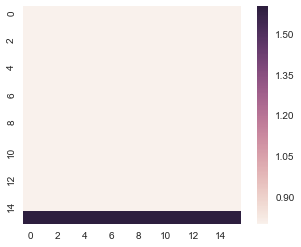

In [164]:
if n < 9:
    sns.heatmap(WLvoltagesList[2], square=True)
else:
    sns.heatmap(WLvoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/camread_mapWL_{}_{}.png".format(pat_type, n), dpi=300, figsize=(10,10))

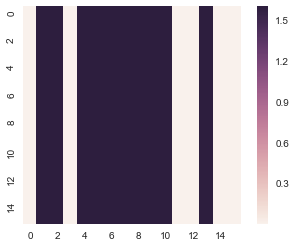

In [165]:
if n < 9:
    sns.heatmap(BLvoltagesList[2], square=True)
else:
    sns.heatmap(BLvoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/camread_mapBL_{}_{}.png".format(pat_type, n), dpi=300, figsize=(10,10))

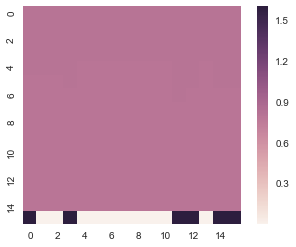

In [166]:
if n < 9:
    sns.heatmap(cellVoltagesList[2], square=True)
else:
    sns.heatmap(cellVoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/camread_mapCell_{}_{}.png".format(pat_type, n), dpi=300, figsize=(10,10))

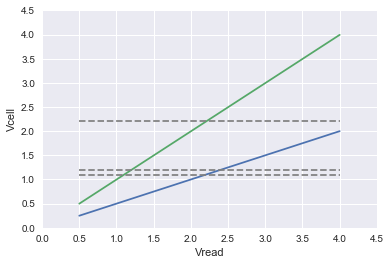

In [167]:
plt.plot(vRead, hubList, vRead, lsbList)
plt.plot([0.5, 4], [1.1, 1.1], [0.5, 4], [2.2, 2.2], c='gray', ls='--')
plt.plot([0.5, 4], [1.2, 1.2], c='gray', ls='--')
plt.xlim([0,4.5])
plt.ylim([0,4.5])
plt.ylabel("Vcell")
plt.xlabel("Vread")
plt.savefig("figures/camread_margin_{}_{}.png".format(pat_type, n), dpi=300, figsize=(10,12))
plt.show()

In [168]:
# Find window
windowlsb = np.interp([1.2, 2.2], lsbList, vRead)
windowhub = np.interp(1.1, hubList, vRead)
print windowlsb
print windowhub

[ 1.20197343  2.20361795]
2.19992119706


In [169]:
# Output data to csv
np.savetxt("data/camread_margin_{}_{}.csv".format(pat_type, n),
           np.vstack((vRead, lsbList, hubList)).T,
           delimiter=',',
           header="Vread,VcellLSB,VcellHUB",
           footer=",WindowLSB = {} - {}, WindowHSB < {}".format(windowlsb[0], windowlsb[1], windowhub),
           comments='')
np.savetxt("data/camread_mapCell_{}_{}.csv".format(pat_type, n),
           cellVoltagesList[2],
           delimiter=',')
np.savetxt("data/camread_mapWL_{}_{}.csv".format(pat_type, n),
           WLvoltagesList[2],
           delimiter=',')
np.savetxt("data/camread_mapBL_{}_{}.csv".format(pat_type, n),
           BLvoltagesList[2],
           delimiter=',')